#  Shea Ackers Modeling of Cbf1
In this notebook, we're going to explore whether including homotypic cooperativity is important for modeling the binding of Cbf1.  The basic strategy is to use the fast Shea-Ackers model that Nik built and applied to Gal4 on Cbf1 data.  
To use the model, we first need to make two text files:  an epsilon matrix, which is just the free energies of binding for each site for each promoter, and a hops.txt (or TPH.txt) file.  These files have to have the same ordering -- row one in the hops.txt file has to give the TPH score of the same promoter that is described by row one of the hops.txt file.   These files can be generated from the comparison frame.

##  Translating from a PWM to a Free Energy Matrix
We have PWMs for all TFs.  How can one translate from a PWM to a free energy matrix?  There are several treatments of this.  Berg and von Hippel have the original work, which is pretty opaque.  Stormo and Fields have a review, but the equation doesn't match the primary literature.  The best reference appears to be "Neural networks for determining protein specificity and multiple alignment of binding sites" by Heumann, Lapedes and Stormo 1994.  

They derive the following relationship between a PWM and the frequency matrix (equation 19 in the paper):

$$W(b,m) = -ln \frac{F(b,m)}{p(b)} $$

Since a PWM has the equation:
$$PWM(b,m) = log_2\frac{F(b,m)}{p(b)}$$

These can be converted by:
$$W(b,m) = -ln(2)*PWM(b,m)$$

However, I got all of my PWMs from Aaron Spivak's database.  He made PFMs and PWMs, but he did not correctly convert the PFM to PWM.  He used 

$$PWM_{Spivak}(b,m) = ln \frac{F(b,m)}{p(b)}$$

where $p(b) =$ {"A":0.32,"C":0.18,"G":0.18,"T":0.32} instead of the usual $p(b)=$ {"A":0.31,"C":0.19,"G":0.19,"T":0.31}

and note that is log base e not log base 2, which is what it should have been, but log base e is actually closer to what is needed for a free energy matrix.

So, to convert a Spivak PWM to a free energy matrix, ignoring the small difference in $p(b)$, one simply does the following:

$$W(b,m) = -PWM_{Spivak}(b,m)$$

In [1]:
cd /home/rmitra/scratch/calling_card_yeast/Cbf1_Tye7_Paper/reanalysis_cbf1tye7_proj/Shea_Ackers_Cbf1

/scratch/rmlab/calling_card_yeast/Cbf1_Tye7_Paper/reanalysis_cbf1tye7_proj/Shea_Ackers_Cbf1


In [2]:
from analyze_sig_hits_v2 import *

In [39]:
cf = make_comparison_frame('../../organized_cbf1tye7_data/FL_Plasmid_Cbf1_Tye7/sig_promoters/sig_prom_CBF1_FL_P_ALL.gnashy.txt',
                           '../../organized_cbf1tye7_data/Swaps/final_sig_promoters/sig_prom_CBF1_DBD_NO_Coil_Final.gnashy.txt'
                           ,'Cbf1_FL','Cbf1_bHLH',True,False)

In [4]:
cf.head()

,Cbf1_FL TPH,Cbf1_FL pvalue,Cbf1_bHLH TPH,Cbf1_bHLH pvalue,Sequence,Log2FC,Left Common Name,Right Common Name
Intergenic Region,,,,,,,,
Chr14: 559003-559815,3160.498088,0.0,260.431572,0.0,"(A, A, A, T, G, G, T, T, C, T, C, A, C, T, G, ...",-3.601176,IDH1,NCE103
Chr10: 683276-684558,2378.282000,0.0,114.475416,0.0,"(G, A, T, G, A, G, T, A, G, C, A, T, C, T, G, ...",-4.376810,ECM17,IML1
Chr14: 116453-117349,2372.530412,0.0,200.331979,0.0,"(C, C, C, T, A, A, C, C, T, G, A, A, C, C, A, ...",-3.565962,CAF120,MET2
Chr4: 1468437-1469393,1978.546573,0.0,231.812718,0.0,"(C, A, T, T, T, T, C, C, G, G, T, T, C, T, A, ...",-3.093409,GNP1,SMT3
Chr16: 74719-75699,1969.919190,0.0,340.564364,0.0,"(C, T, T, G, C, T, G, G, T, A, A, G, A, T, T, ...",-2.532137,ICY2,RPL36B


# Making an Epsilon File for Shea-Ackers in matlab
In principle, we could compute the free energy of binding for every base pair in all bound and/or unbound promoters.  However, for Gal4, I put a cutoff to only select the strong sites, since very weak sites will not contribute much, if anything to the computation, and the code will run much faster this way.  I will do the same here, using a PWM/Free Energy cutoff of 5.  Also, since matlab likes matrices, I square the matrix by adding 999's to the matrix. (Although this implementation is in fully in python, the files are compatible with both python and matlab versions).  So the procedure is 1) grab bound and some unbound sites.  2)  Score the sequences with the Spivak PWM with a cutoff of five and multiply by -1.  3)  Square the matrix by adding 999's to the matrix. 4) Print the matrix to a file

In [5]:
cbf1_bound = cf[cf["Cbf1_FL pvalue"]<1.1e-5]

In [6]:
len(cbf1_bound)

161

In [7]:
cbf1_for_epsilon = cbf1_bound.copy()

In [8]:
cbf1_for_epsilon = add_pwm_info(cbf1_for_epsilon,'cbf1',5)

In [9]:
def compute_distance(x):
    if x:
        return x[-1] - x[0]
    else:
        return 0

In [10]:
cbf1_for_epsilon["site_distance"]=cbf1_for_epsilon["cbf1 pos"].apply(lambda x: compute_distance(x))

In [11]:
cbf1_for_epsilon

,Cbf1_FL TPH,Cbf1_FL pvalue,Cbf1_bHLH TPH,Cbf1_bHLH pvalue,Sequence,Log2FC,Left Common Name,Right Common Name,cbf1 pos,cbf1 score,cbf1 orientaion,site_distance
Intergenic Region,,,,,,,,,,,,
Chr14: 559003-559815,3160.498088,0.000000e+00,260.431572,0.000000e+00,"(A, A, A, T, G, G, T, T, C, T, C, A, C, T, G, ...",-3.601176,IDH1,NCE103,"[550, 613, 624]","[9.7, 9.7, 11.38]","[-1, -1, 1]",74
Chr10: 683276-684558,2378.282000,0.000000e+00,114.475416,0.000000e+00,"(G, A, T, G, A, G, T, A, G, C, A, T, C, T, G, ...",-4.376810,ECM17,IML1,"[457, 477, 1303]","[9.7, 9.7, 11.38]","[-1, 1, -1]",846
Chr14: 116453-117349,2372.530412,0.000000e+00,200.331979,0.000000e+00,"(C, C, C, T, A, A, C, C, T, G, A, A, C, C, A, ...",-3.565962,CAF120,MET2,"[381, 507, 701]","[7.91, 9.7, 9.7]","[-1, -1, -1]",320
Chr4: 1468437-1469393,1978.546573,0.000000e+00,231.812718,0.000000e+00,"(C, A, T, T, T, T, C, C, G, G, T, T, C, T, A, ...",-3.093409,GNP1,SMT3,"[838, 849, 876, 924]","[9.7, 5.99, 6.23, 5.73]","[1, 1, 1, -1]",86
Chr16: 74719-75699,1969.919190,0.000000e+00,340.564364,0.000000e+00,"(C, T, T, G, C, T, G, G, T, A, A, G, A, T, T, ...",-2.532137,ICY2,RPL36B,"[512, 881, 922]","[11.38, 6.09, 11.38]","[1, 1, -1]",410
Chr11: 428194-428945,1475.282547,0.000000e+00,160.265583,1.110223e-16,"(T, A, G, C, A, G, C, C, G, T, T, T, T, A, G, ...",-3.202455,LAC1,CAP1,"[727, 743, 745]","[9.7, 11.38, 6.23]","[-1, -1, 1]",18
Chr10: 454674-456232,1400.511891,0.000000e+00,457.901666,0.000000e+00,"(G, A, G, T, A, G, A, G, T, C, G, T, A, C, T, ...",-1.612845,TDH2,MET3,"[545, 1339, 1347]","[9.7, 11.38, 11.38]","[1, -1, 1]",802
Chr13: 29807-32334,1354.499180,0.000000e+00,48.652052,2.506542e-01,"(T, G, T, G, C, T, G, A, G, G, G, T, C, A, A, ...",-4.799115,NDI1,NGL3,"[711, 713]","[7.88, 6.97]","[-1, 1]",2
Chr11: 407632-408187,1325.741236,0.000000e+00,329.116822,0.000000e+00,"(G, T, T, G, A, C, T, T, T, G, C, A, G, C, T, ...",-2.010128,ATP7,PUT3,"[233, 411, 422, 449]","[5.71, 11.38, 9.7, 9.7]","[1, 1, 1, -1]",216


In [12]:
cbf1_for_epsilon = cbf1_for_epsilon[cbf1_for_epsilon["site_distance"]<500]

In [13]:
len(cbf1_for_epsilon)

127

In [14]:
epilson_series = cbf1_for_epsilon["cbf1 score"].apply(lambda x: [y*-1 for y in x])

In [15]:
epilson_series.head()

Intergenic Region
Chr14: 559003-559815            [-9.7, -9.7, -11.38]
Chr14: 116453-117349             [-7.91, -9.7, -9.7]
Chr4: 1468437-1469393    [-9.7, -5.99, -6.23, -5.73]
Chr16: 74719-75699           [-11.38, -6.09, -11.38]
Chr11: 428194-428945           [-9.7, -11.38, -6.23]
Name: cbf1 score, dtype: object

In [16]:
max_sites = max(epilson_series.apply(len))

In [17]:
epilson_series = epilson_series.apply(lambda x: x+[999]*(max_sites-len(x)))

In [18]:
epilson_series.head()

Intergenic Region
Chr14: 559003-559815        [-9.7, -9.7, -11.38, 999]
Chr14: 116453-117349         [-7.91, -9.7, -9.7, 999]
Chr4: 1468437-1469393     [-9.7, -5.99, -6.23, -5.73]
Chr16: 74719-75699       [-11.38, -6.09, -11.38, 999]
Chr11: 428194-428945       [-9.7, -11.38, -6.23, 999]
Name: cbf1 score, dtype: object

In [19]:
f1=open('./epsilon_cbf1.txt', 'w+')

for line in epilson_series:
    print >> f1,"\t".join(map(str,line)) 

f1.close()

## Making the TPHBS_Cbf1.txt file

In [20]:
hops = cbf1_for_epsilon["Cbf1_FL TPH"]

In [21]:
f1=open('./TPHBS_cbf1.txt', 'w+')

for line in hops:
    print >> f1,line

f1.close()

In [22]:
len(epilson_series)

127

In [23]:
run /scratch/rmlab/jupyter/Rob/gal4_shea_ackers/thermo3

In [24]:
epsilon = pd.read_csv("epsilon_cbf1.txt",sep="\t",header=None)

In [25]:
hops = pd.read_csv("TPHBS_cbf1.txt",sep="\t",header=None)

In [26]:
hops.head()

,0
0,3160.498088
1,2372.530412
2,1978.546573
3,1969.919190
4,1475.282547


Correlation = 0.72


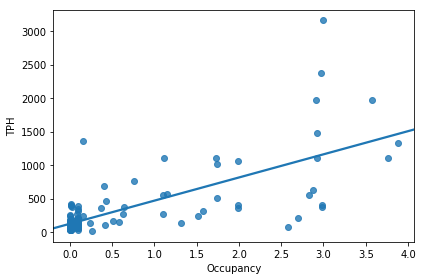

In [40]:
outframe_coop = fast_shea_ackers_series(epsilon,hops,1,-10,0.00000114)

Correlation = 0.69


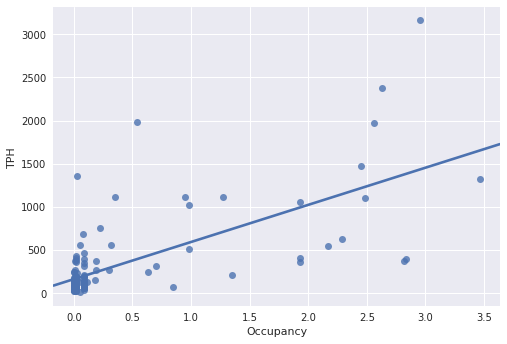

In [28]:
outframe_coop = fast_shea_ackers_series(epsilon,hops,1,-8,0.00000114)

Correlation = 0.62


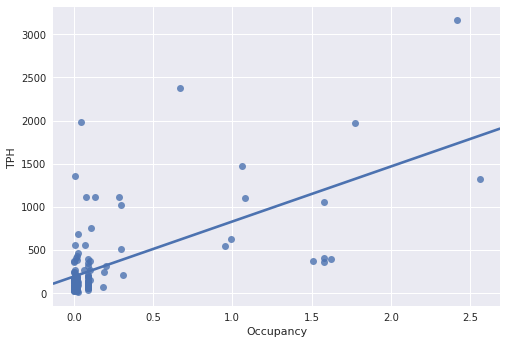

In [29]:
outframe_coop = fast_shea_ackers_series(epsilon,hops,1,-6,0.00000114)

Correlation = 0.53


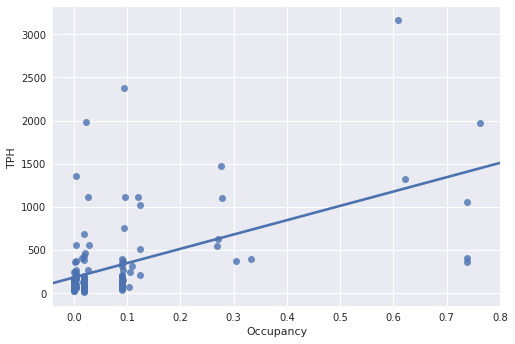

In [30]:
outframe_coop = fast_shea_ackers_series(epsilon,hops,1,-4,0.00000114)

Correlation = 0.41


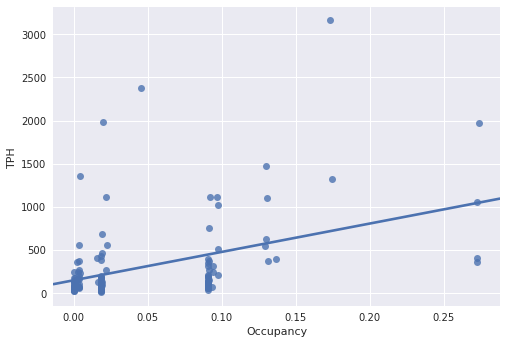

In [31]:
outframe_coop = fast_shea_ackers_series(epsilon,hops,1,-2,0.00000114)

Correlation = 0.35


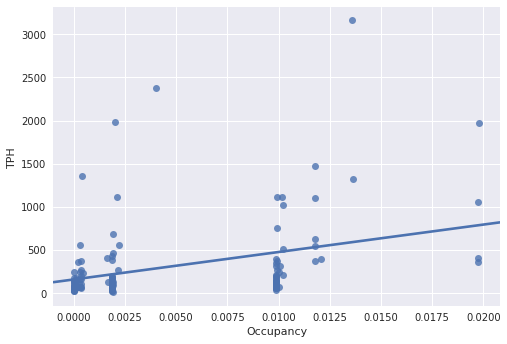

In [32]:
outframe_nocoop = fast_shea_ackers_series(epsilon,hops,1,0,0.000000114)

In [33]:
sns.reset_orig()

Let's make the scatterplots look a little prettier:

In [34]:
run ~/scratch/jupyter/Rob/gal4_scatterplot.py

In [42]:
outframe_coop.columns = ["Predicted Occupancy","Observed Binding (TPH)"]

0.721110255093
(0.71848009190195217, 1.9226670072625349e-21)


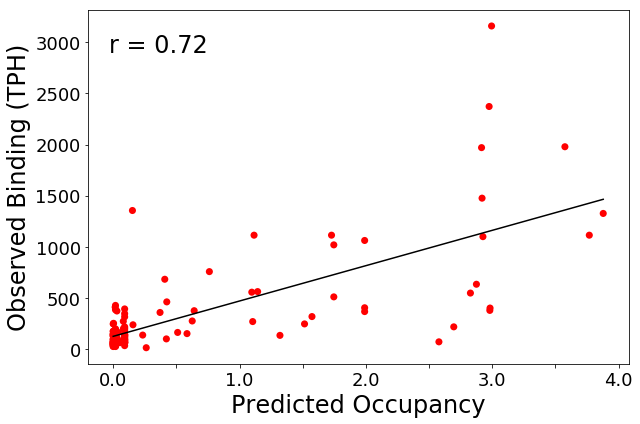

In [43]:
scatterplot_cc(outframe_coop,"Predicted Occupancy","Observed Binding (TPH)")

In [37]:
outframe_nocoop.columns = ["Predicted Occupancy","Observed Binding (TPH)"]

0.346410161514
(0.34787166437647038, 6.1375875355553519e-05)


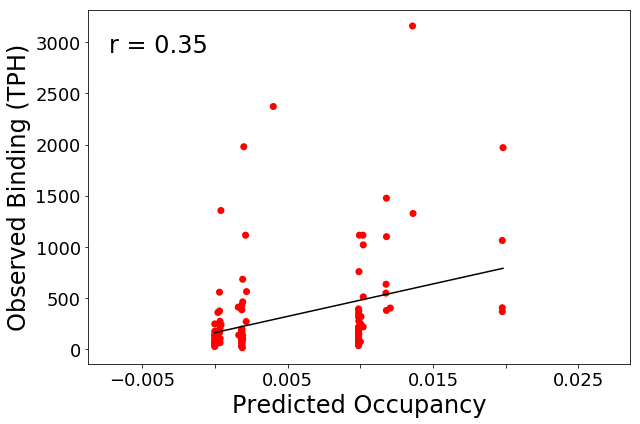

In [38]:
scatterplot_cc(outframe_nocoop,"Predicted Occupancy","Observed Binding (TPH)")